In [13]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing import timeseries_dataset_from_array


In [14]:
# load the ED visits dataset that has been cleaned and preprocessed
df_event_log_dl = pd.read_csv('df_event_log_visits_for_ML.csv')

In [15]:
df_event_log_dl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301205 entries, 0 to 301204
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             301205 non-null  object 
 1   SEX                             301205 non-null  int64  
 2   VISIT_ID                        301205 non-null  object 
 3   VISIT_AGE                       301205 non-null  float64
 4   CTAS                            301205 non-null  float64
 5   Case_Duration_Hours             301205 non-null  float64
 6   Is_Deceased                     301205 non-null  int64  
 7   Distance_to_Hospital            301205 non-null  float64
 8   Is_NL_Holiday                   301205 non-null  bool   
 9   Day_of_Week                     301205 non-null  int64  
 10  Is_Weekend                      301205 non-null  bool   
 11  Visit_Frequency                 301205 non-null  int64  
 12  Prior_LWBS      

## Case Features:
Case features are attributes that are the same across all events within a single case (visit). 

In this case:

SID - Patient or session identifier (will be omitted for modeling as it doesn't add predictive value).

SEX - remains constant per case.

VISIT_ID - Case identifier - identifies the specific visit; constant for all events within that visit.

VISIT_AGE - Age of the patient, constant for the visit.

Is_Deceased - case attribute.

Distance_to_Hospital - constant for a given visit.

Is_NL_Holiday - constant for the visit.

Day_of_Week - constant for the visit.

Is_Weekend - constant for the visit.

Visit_Frequency - case-level feature.

Prior_LWBS - case-level feature.

Facility_IDs - case-level features.

Case_Duration_Hours - Duration of the case or visit, case-level feature.

TOTAL_PRECIPITATION - case-level features.

Imaging_Done - Whether imaging was done; specific to a case. 

Labs_Done - Whether lab tests were done; specific to a case. 

TIME_OF_THE_DAY_Ordinal - time of the day at the arrival of the patient, case-level feature.

Visit_Season_Ordinal - Season of the visit, specific to a case. 

## Event Features:
Event features are those that can vary from one event to another within the same visit:

CTAS - Triage score which can change if re-triaged during a visit.

ED_Business_Hourly - How busy the ED was, potentially varying hourly.

Activity_Encoded - varies by activity occurring during the visit. 

Is_LWBS - Indicates if the patient left without being seen, which is 
an outcome or event-specific feature.

Activity_Duration - Duration of specific activities within a visit.

Disposition_Frequency - Frequency of specific dispositions within the case, which could potentially vary as events unfold.

In [16]:
# Dropping the 'SID' column from the DataFrame
df_event_log_dl = df_event_log_dl.drop('SID', axis=1)

df_event_log_dl.head()

,SEX,VISIT_ID,VISIT_AGE,CTAS,Case_Duration_Hours,Is_Deceased,Distance_to_Hospital,Is_NL_Holiday,Day_of_Week,Is_Weekend,...,Activity_Making admit decision,Activity_Patient departed,Activity_Patient discharge,Activity_Providing service,Activity_Triage,Is_LWBS,TIME_OF_THE_DAY_Ordinal,Visit_Season_Ordinal,Activity_Duration,Disposition_Frequency
0,1,VISIT2208402,62.750000,3.0,0.550000,0,22.23370,False,4,False,...,False,False,False,False,True,0,0.0,1.0,0.033333,0.714286
1,1,VISIT2208402,62.750000,3.0,0.550000,0,22.23370,False,4,False,...,False,False,False,True,False,0,0.0,1.0,0.100000,0.714286
2,1,VISIT2208402,62.750000,3.0,0.550000,0,22.23370,False,4,False,...,False,False,False,False,False,0,0.0,1.0,0.416667,0.714286
3,1,VISIT2208402,62.750000,3.0,0.550000,0,22.23370,False,4,False,...,False,True,False,False,False,0,0.0,1.0,0.000000,0.714286
4,0,VISIT2208404,23.166667,4.0,5.333333,0,0.42978,False,4,False,...,False,False,False,False,True,0,0.0,1.0,0.066667,1.000000


In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

In [18]:
from sklearn.model_selection import train_test_split

# 'Is_LWBS' is the target variable
X = df_event_log_dl.drop(['Is_LWBS', 'VISIT_ID'], axis=1)  # Drop non-feature and identifier columns
y = df_event_log_dl['Is_LWBS']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Use stratify for balanced splits on the target variable

# creating a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 25% of the original training data for validation


In [19]:
# changing the booleans
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)


In [20]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

sequence_length = 7  

# Creating timeseries datasets for training, validation, and testing
train_dataset = timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sequence_length=sequence_length,
    sequence_stride=1,
    batch_size=128
)

val_dataset = timeseries_dataset_from_array(
    data=X_val,
    targets=y_val,
    sequence_length=sequence_length,
    sequence_stride=1,
    batch_size=128
)

test_dataset = timeseries_dataset_from_array(
    data=X_test,
    targets=y_test,
    sequence_length=sequence_length,
    sequence_stride=1,
    batch_size=128
)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=(sequence_length, X_train.shape[1]), activation='relu'),  # Ensure input shape alignment
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
1412/1412 [==============================] - 204s 141ms/step - loss: 0.3548 - accuracy: 0.9019 - val_loss: 0.1675 - val_accuracy: 0.9429
Epoch 2/10
1412/1412 [==============================] - 194s 138ms/step - loss: 0.1211 - accuracy: 0.9519 - val_loss: 0.1005 - val_accuracy: 0.9571
Epoch 3/10
1412/1412 [==============================] - 195s 138ms/step - loss: 0.0933 - accuracy: 0.9583 - val_loss: 0.0882 - val_accuracy: 0.9595
Epoch 4/10
1412/1412 [==============================] - 196s 139ms/step - loss: 0.0739 - accuracy: 0.9656 - val_loss: 0.0582 - val_accuracy: 0.9756
Epoch 5/10
1412/1412 [==============================] - 196s 139ms/step - loss: 0.0544 - accuracy: 0.9776 - val_loss: 0.0416 - val_accuracy: 0.9842
Epoch 6/10
1412/1412 [==============================] - 203s 143ms/step - loss: 0.0406 - accuracy: 0.9845 - val_loss: 0.0295 - val_accuracy: 0.9892
Epoch 7/10
1412/1412 [==============================] - 206s 146ms/step - loss: 0.0381 - accuracy: 0.9855 - val_

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_model(input_shape):
    model = Sequential([
        LSTM(50, input_shape=input_shape, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Creating a new instance of the model
model = create_model((sequence_length, X_train.shape[1]))

history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)



Epoch 1/10
1412/1412 [==============================] - 198s 138ms/step - loss: 0.4440 - accuracy: 0.8816 - val_loss: 0.3605 - val_accuracy: 0.8876
Epoch 2/10
1412/1412 [==============================] - 197s 139ms/step - loss: 0.1716 - accuracy: 0.9321 - val_loss: 0.1118 - val_accuracy: 0.9487
Epoch 3/10
1412/1412 [==============================] - 196s 139ms/step - loss: 0.1144 - accuracy: 0.9491 - val_loss: 0.1030 - val_accuracy: 0.9513
Epoch 4/10
1412/1412 [==============================] - 195s 138ms/step - loss: 0.0957 - accuracy: 0.9543 - val_loss: 0.0877 - val_accuracy: 0.9575
Epoch 5/10
1412/1412 [==============================] - 196s 139ms/step - loss: 0.0906 - accuracy: 0.9587 - val_loss: 0.0828 - val_accuracy: 0.9660
Epoch 6/10
1412/1412 [==============================] - 198s 141ms/step - loss: 0.0660 - accuracy: 0.9722 - val_loss: 0.0576 - val_accuracy: 0.9770
Epoch 7/10
1412/1412 [==============================] - 195s 138ms/step - loss: 0.0581 - accuracy: 0.9763 - val_

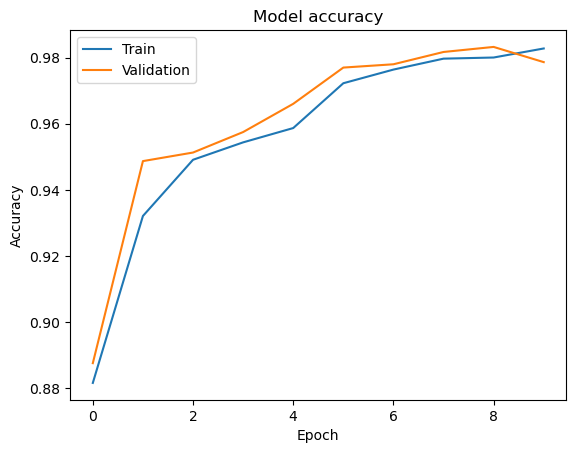

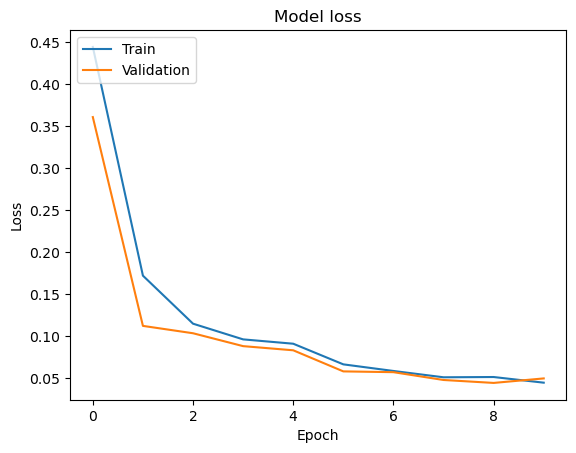

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [24]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


471/471 [==============================] - 49s 104ms/step - loss: 0.0471 - accuracy: 0.9793
Test Loss: 0.04705430194735527
Test Accuracy: 0.9792645573616028


In [ ]:
git add deep_learning_model.ipynb